In [2]:
"""
PGA Tournament Winner Prediction Projects:
Features: 
    -world rank
    -projections
    -performance in all recent tournament
    -performances in same tournament
    -performances in same course
    -whether it's a major

Notes:
    -Model will predict one person’s position.
    Can just put each of the last maybe 10 positions of this years tournament, 
    and the last 5 of this course) train on last years data? It will have to train 
    on each of the last like 20 or so tournaments with the data from before them

API docs: https://sportsdata.io/developers/api-documentation/golf# 
API Key:
917bd281e6f04f44997a173fb9fa4edf

Sample API curl:
curl https://api.sportsdata.io/golf/v2/json/Leaderboard/58 \
-H "Ocp-Apim-Subscription-Key: 917bd281e6f04f44997a173fb9fa4edf"

curl https://api.sportsdata.io/golf/v2/json/Player/40001199 \
-H "Ocp-Apim-Subscription-Key: 917bd281e6f04f44997a173fb9fa4edf" \
> /Users/huntermitchell/Documents/PYTHON_FILES/PGA_Winners_Prediction/player_output2.json

curl https://api.sportsdata.io/golf/v2/json/PlayerTournamentStatsByPlayer/420/40001199 \
-H "Ocp-Apim-Subscription-Key: 917bd281e6f04f44997a173fb9fa4edf" \
> /Users/huntermitchell/Documents/PYTHON_FILES/PGA_Winners_Prediction/player_tournament_output2.json

curl https://api.sportsdata.io/golf/v2/json/Tournaments \
-H "Ocp-Apim-Subscription-Key: 917bd281e6f04f44997a173fb9fa4edf" \
> /Users/huntermitchell/Documents/PYTHON_FILES/PGA_Winners_Prediction/tournaments_output1.json

curl https://api.sportsdata.io/golf/v2/json/Players \
-H "Ocp-Apim-Subscription-Key: 917bd281e6f04f44997a173fb9fa4edf" \
> /Users/huntermitchell/Documents/PYTHON_FILES/PGA_Winners_Prediction/players_output.json
"""

'\nPGA Tournament Winner Prediction Projects:\nFeatures: \n    -world rank\n    -projections\n    -performance in all recent tournament\n    -performances in same tournament\n    -performances in same course\n    -whether it\'s a major\n\nNotes:\n    -Model will predict one person’s position.\n    Can just put each of the last maybe 10 positions of this years tournament, \n    and the last 5 of this course) train on last years data? It will have to train \n    on each of the last like 20 or so tournaments with the data from before them\n\nAPI docs: https://sportsdata.io/developers/api-documentation/golf# \nAPI Key:\n917bd281e6f04f44997a173fb9fa4edf\n\nSample API curl:\ncurl https://api.sportsdata.io/golf/v2/json/Leaderboard/58 -H "Ocp-Apim-Subscription-Key: 917bd281e6f04f44997a173fb9fa4edf"\n\ncurl https://api.sportsdata.io/golf/v2/json/Player/40001199 -H "Ocp-Apim-Subscription-Key: 917bd281e6f04f44997a173fb9fa4edf" > /Users/huntermitchell/Documents/PYTHON_FILES/PGA_Winners_Prediction/

In [1]:
import os
import requests
import json
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [16]:
PLAYER = "Scottie Scheffler"

In [6]:
TOURNAMENTS_URL = "https://api.sportsdata.io/golf/v2/json/Tournaments"

PLAYERS_URL = "https://api.sportsdata.io/golf/v2/json/Players"

LEADERBOARDS_URL = "https://api.sportsdata.io/golf/v2/json/Leaderboard/{}"

SEASON_URL = "https://api.sportsdata.io/golf/v2/json/PlayerSeasonStats/{}"

PROJECT_PATH = '/Users/huntermitchell/Documents/Documents/PYTHON_FILES/PGA_Winners_Prediction'

API_KEY = "917bd281e6f04f44997a173fb9fa4edf" # mine

SEED = '15'

In [24]:
def get_players_df(new_request=False):
    if new_request:
        response = requests.get(PLAYERS_URL,
                                headers={"Ocp-Apim-Subscription-Key": API_KEY})
        players_df = pd.DataFrame(response.json())
        print(f'Overwriting {PROJECT_PATH}/players.csv')
        players_df.to_csv(f'{PROJECT_PATH}/players.csv', index=False)
    else:
        print(f'Getting players data from {PROJECT_PATH}/players.csv')
        players_df = pd.read_csv(f'{PROJECT_PATH}/players.csv')
    return players_df


def get_player_id(players_df):
    return players_df[(players_df.FirstName == PLAYER.split(' ')[0]) & 
                       (players_df.LastName == PLAYER.split(' ')[1])]['PlayerID'].values[0]


def get_tournaments_df(new_request=False):
    if new_request:
        response = requests.get(TOURNAMENTS_URL,
                        headers={"Ocp-Apim-Subscription-Key": API_KEY})
        tournaments_df = pd.DataFrame(response.json())
        print(f'Overwriting {PROJECT_PATH}/tournaments.csv')
        tournaments_df.to_csv(f'{PROJECT_PATH}/tournaments.csv',index=False)
    else:
        print(f'Getting tournament data from {PROJECT_PATH}/tournaments.csv')
        tournaments_df = pd.read_csv(f'{PROJECT_PATH}/tournaments.csv')
    return tournaments_df


def get_next_tournament_info(tournaments_df):
    tournaments_df['EndDate'] = tournaments_df['EndDate'].apply(lambda x: datetime.strptime(str(x)[:10], '%Y-%m-%d'))
    return tournaments_df[tournaments_df.EndDate > datetime.today()].sort_values(by='StartDate')[['TournamentID','Name']].iloc[0]


def get_player_data(leaderboard_df, player_id):
    try:
        player = leaderboard_df[leaderboard_df['PlayerID']==player_id]
        odds_to_win = player['OddsToWin'].values[0]
        if player['IsWithdrawn'].values[0]: return 'WD', odds_to_win
        else:
            score = player['TotalScore'].values[0]
            if math.isnan(score):
                return 'CUT', odds_to_win
            else: return float(leaderboard_df[leaderboard_df['TotalScore']==score].index[0] + 1), odds_to_win
    except Exception as E:
        return None, None


def write_leaderboard_data(tournament_ids):
    print('Writing all tournament data to disk...')
    for tournament in tournament_ids:
        if tournament%10==0: print(f'On tournament {tournament}')
        file_path = f'{PROJECT_PATH}/leaderboards/tournament_{tournament}.csv'
        if not os.path.isfile(file_path):
            response = requests.get(LEADERBOARDS_URL.format(tournament),
                                    headers={"Ocp-Apim-Subscription-Key": API_KEY})
            pd.DataFrame(response.json()['Players']).to_csv(f'{PROJECT_PATH}/leaderboards/tournament_{tournament}.csv',
                                                        index=False)

def get_leaderboard_data(tournament_ids, player_id):
    data=[]
    for tournament in tournament_ids:
        try: data.append([tournament,
                     *get_player_data(pd.read_csv(f'{PROJECT_PATH}/leaderboards/tournament_{tournament}.csv'),
                                      player_id)])
        except Exception as E:
            pass
    return data


def get_slope(Y):
    X = list(range(1,len(Y)+1))
    return round(np.polyfit(X,Y,1)[0]*-1,2)


def prep_data(df):
    # remove tournaments they weren't in
    df = df[(~df['Position'].isna()) & (df['Position']!='WD')]

    # convert CUTs to position 75.0
    df['Position'] = df['Position'].apply(lambda x: x if x!='CUT' else 75.0)
    
    df['Position'] = df['Position'].astype('float')

    df['Last10PositionAvg'] = df['Position'].shift(-1).rolling(10).mean().shift(-9)
    df['Last5PositionAvg'] = df['Position'].shift(-1).rolling(5).mean().shift(-4)
    df['Last3PositionAvg'] = df['Position'].shift(-1).rolling(3).mean().shift(-2)
    
    df['Last10PositionSlope'] = df['Position'].shift(-1).rolling(10).apply(get_slope).shift(-9)
    df['Last5PositionSlope'] = df['Position'].shift(-1).rolling(5).apply(get_slope).shift(-4)
    df['Last3PositionSlope'] = df['Position'].shift(-1).rolling(3).apply(get_slope).shift(-2)
    
    # need to fix. Venues can be named differently. And course avg includes current tournament
    #df = df.join(tournaments_df.set_index('TournamentID')['Venue'], how='left', lsuffix='_left', rsuffix='_right')
    #df['CourseAvg'] = df.groupby('Venue')['Position'].transform('mean')
    #df = df.drop(columns='Venue').sort_index(ascending=False)
    
    # cut oldest 10 which don't have all data
    df = df[:-10]

    return df


def plot(x_label, y_label, df):
    plt.figure(figsize=(10,10))

    x = df[x_label].values
    y = df[y_label].values
    plt.scatter(x, y)

    m, b = np.polyfit(x, y, 1)

    plt.plot(x, m*x+b)

    plt.xlabel(x_label)
    plt.ylabel(y_label)


def get_score(model):
  cv_score = cross_val_score(model, x_train, y_train, scoring = "neg_mean_squared_error", cv = 8)
  rmse = np.sqrt(-cv_score)
  print('Cross-Validation Root Mean Squared Error:', rmse)
  print('Average Root Mean Squared Error:', round(np.mean(rmse), 5))
  print('Standard deviation:', round(rmse.std(), 5))


def get_results(preds):
  score = np.sqrt(mean_squared_error(preds,y_test.values))
  print(f"Final RMSE: {round(score,5)}")


In [17]:
players_df = get_players_df(new_request=False)

In [18]:
PLAYER_ID = get_player_id(players_df)

In [19]:
print(f'Player {PLAYER} is PLAYER_ID={PLAYER_ID}')

Player Scottie Scheffler is PLAYER_ID=40001274


In [11]:
tournaments_df = get_tournaments_df(new_request=False)

In [26]:
tournaments_df[tournaments_df['IsOver'] == True]

,TournamentID,Name,StartDate,EndDate,IsOver,IsInProgress,Venue,Location,Par,Yards,...,Covered,City,State,ZipCode,Country,TimeZone,Format,SportRadarTournamentID,OddsCoverage,Rounds
53,561,FedEx St. Jude Championship,2023-08-10T00:00:00,2023-08-13,True,False,TPC Southwind,"Memphis, TN",70.0,7243.0,...,True,Memphis,TN,None,USA,America/Chicago,Stroke,,Full,"[{'TournamentID': 561, 'RoundID': 19766, 'Numb..."
54,560,Wyndham Championship,2023-08-03T00:00:00,2023-08-06,True,False,Sedgefield Country Club,"Greensboro, NC",70.0,7131.0,...,True,Greensboro,NC,None,USA,America/New York,Stroke,ba485e45-67e1-42bd-832f-4178fba750cc,Full,"[{'TournamentID': 560, 'RoundID': 19762, 'Numb..."
55,559,3M Open,2023-07-27T00:00:00,2023-07-30,True,False,TPC Twin Cities,"Blaine, MN",71.0,7431.0,...,True,Blaine,MN,None,USA,America/Chicago,Stroke,704576a7-e3be-4958-984d-0c5784af55b7,Full,"[{'TournamentID': 559, 'RoundID': 19758, 'Numb..."
57,558,The Open,2023-07-20T00:00:00,2023-07-23,True,False,Royal Liverpool,"Hoylake, Wirral, Eng",71.0,7383.0,...,True,"Hoylake, Wirral",None,None,ENG,Europe/London,Stroke,,Full,"[{'TournamentID': 558, 'RoundID': 19754, 'Numb..."
58,555,Barbasol Championship,2023-07-13T00:00:00,2023-07-16,True,False,Keene Trace Golf Club (Champions Course),"Nicholasville, KY",72.0,7328.0,...,True,Nicholasville,KY,None,USA,America/New York,Stroke,53cf1088-f9b4-424e-ab11-9a1cdd4eb7c2,Full,"[{'TournamentID': 555, 'RoundID': 19742, 'Numb..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,42,World Golf Championships-HSBC Champions,2014-11-06T00:00:00,2014-11-09,True,False,Sheshan International GC,"Shanghai, China",72.0,7261.0,...,True,None,None,None,None,None,None,,Full,"[{'TournamentID': 42, 'RoundID': 159, 'Number'..."
504,50,CIMB Classic,2014-10-30T00:00:00,2014-11-02,True,False,Kuala Lumpur G&CC,"Kuala Lumpur, Malaysia",72.0,6985.0,...,True,None,None,None,None,None,None,,Full,"[{'TournamentID': 50, 'RoundID': 191, 'Number'..."
505,51,The McGladrey Classic,2014-10-23T00:00:00,2014-10-26,True,False,Sea Island Resort (Seaside),"Sea Island, GA",70.0,7005.0,...,True,None,None,None,None,None,None,,Full,"[{'TournamentID': 51, 'RoundID': 195, 'Number'..."
506,36,Shriners Hospitals for Children Open,2014-10-16T00:00:00,2014-10-19,True,False,TPC Summerlin,"Las Vegas, NV",71.0,7255.0,...,True,None,None,None,None,None,None,,Full,"[{'TournamentID': 36, 'RoundID': 135, 'Number'..."


In [20]:
TOURNAMENT_ID, TOURNAMENT_NAME = get_next_tournament_info(tournaments_df)

In [21]:
print(f'Predicting {PLAYER} for\nTOURNAMENT_ID: {TOURNAMENT_ID}\nTOURNAMENT_NAME: {TOURNAMENT_NAME}')

Predicting Scottie Scheffler for
TOURNAMENT_ID: 562
TOURNAMENT_NAME: BMW Championship


## Prepping Data:

In [22]:
tournament_ids = [TOURNAMENT_ID] + list(tournaments_df[tournaments_df['IsOver']==True]['TournamentID'].unique())

In [23]:
print(f'Using data from {len(tournament_ids)} tournaments')

Using data from 410 tournaments


In [25]:
%%time

# # Write leaderboard CSVs for use later
write_leaderboard_data(tournament_ids)

Writing all tournament data to disk...
On tournament 560
On tournament 550
On tournament 540
On tournament 530
On tournament 520
On tournament 500
On tournament 490
On tournament 480
On tournament 470
On tournament 450
On tournament 440
On tournament 430
On tournament 420
On tournament 410
On tournament 380
On tournament 360
On tournament 340
On tournament 330
On tournament 320
On tournament 310
On tournament 300
On tournament 280
On tournament 270
On tournament 260
On tournament 250
On tournament 230
On tournament 140
On tournament 130
On tournament 120
On tournament 160
On tournament 110
On tournament 90
On tournament 80
On tournament 70
On tournament 60
On tournament 20
On tournament 40
On tournament 30
On tournament 10
On tournament 50
CPU times: user 4.81 s, sys: 415 ms, total: 5.23 s
Wall time: 1min 21s


In [48]:
tourn_id = 558
plyer_id = 40001274

In [49]:
temp_df = pd.read_csv(f'{PROJECT_PATH}/leaderboards/tournament_{tourn_id}.csv')

In [53]:
temp_df

,PlayerTournamentID,PlayerID,TournamentID,Name,Rank,Country,TotalScore,TotalStrokes,TotalThrough,Earnings,...,FantasyPointsFantasyDraft,StreaksOfFourBirdiesOrBetter,StreaksOfFiveBirdiesOrBetter,ConsecutiveBirdieOrBetterCount,BounceBackCount,RoundsWithFiveOrMoreBirdiesOrBetter,IsWithdrawn,FantasyPointsYahoo,StreaksOfSixBirdiesOrBetter,Rounds
0,64190,40000585,558,Brian Harman,0.0,USA,-8.2,171.0,NaN,1893000.0,...,107.9,0.4,0.0,2.8,1.6,0.4,False,75.5,0.0,"[{'PlayerRoundID': 171267, 'PlayerTournamentID..."
1,64169,40000314,558,Jason Day,1.0,Australia,-4.4,174.8,NaN,684398.4,...,89.0,0.0,0.0,1.2,1.2,0.4,False,49.9,0.0,"[{'PlayerRoundID': 171227, 'PlayerTournamentID..."
2,64217,40004287,558,Joo-Hyung Kim,1.0,South Korea,-4.4,174.8,NaN,684398.4,...,90.9,0.0,0.0,2.0,0.8,0.4,False,54.6,0.0,"[{'PlayerRoundID': 171317, 'PlayerTournamentID..."
3,64255,40001199,558,Jon Rahm,1.0,Spain,-4.4,174.8,NaN,684398.4,...,92.8,0.4,0.0,2.0,0.0,0.4,False,56.7,0.0,"[{'PlayerRoundID': 171393, 'PlayerTournamentID..."
4,64281,40002785,558,Sepp Straka,1.0,Austria,-4.4,174.8,NaN,684398.4,...,97.2,0.4,0.0,2.8,0.8,1.2,False,54.9,0.0,"[{'PlayerRoundID': 171441, 'PlayerTournamentID..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,64295,40005623,558,Kazuki Yasumori,NaN,Japan,NaN,92.1,NaN,NaN,...,21.5,0.0,0.0,0.4,0.0,0.0,False,5.7,0.0,"[{'PlayerRoundID': 171489, 'PlayerTournamentID..."
153,64297,40005711,558,Jose Luis Ballester Barrio,NaN,NaN,NaN,92.8,NaN,NaN,...,25.2,0.0,0.0,0.0,0.8,0.0,False,4.9,0.0,"[{'PlayerRoundID': 171491, 'PlayerTournamentID..."
154,64298,40005712,558,Alex Maguire,NaN,NaN,NaN,95.9,NaN,NaN,...,16.4,0.0,0.0,0.0,0.4,0.0,False,-2.5,0.0,"[{'PlayerRoundID': 171493, 'PlayerTournamentID..."
155,64299,40005713,558,Connor McKinney,NaN,NaN,NaN,96.5,NaN,NaN,...,15.8,0.0,0.0,0.0,0.8,0.0,False,0.4,0.0,"[{'PlayerRoundID': 171471, 'PlayerTournamentID..."


In [124]:
%%time
data = get_leaderboard_data(tournament_ids, PLAYER_ID)

CPU times: user 8.96 s, sys: 1.67 s, total: 10.6 s
Wall time: 13.6 s


In [125]:
df_raw = pd.DataFrame(data,columns=['TournamentID','Position','Odds']).set_index('TournamentID')

In [130]:
df = prep_data(df_raw)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [167]:
df_next_tournament = df[df.index == TOURNAMENT_ID]

In [169]:
df = df[1:]

## Analysis

In [170]:
df.head(10)

,Position,Odds,Last10PositionAvg,Last5PositionAvg,Last3PositionAvg,Last10PositionSlope,Last5PositionSlope,Last3PositionSlope
TournamentID,,,,,,,,
526,25.0,10.5,35.8,23.0,16.666667,-3.88,-2.8,0.0
524,5.0,11.2,35.4,32.6,32.333333,0.07,-3.4,-6.0
520,40.0,15.5,31.9,39.6,23.333333,1.42,-14.1,-4.0
509,5.0,22.1,34.9,46.0,39.333333,3.05,-3.2,-0.5
508,52.0,22.9,30.5,36.2,47.000000,3.38,3.6,-31.0
507,13.0,19.0,29.5,48.6,55.000000,6.04,2.8,8.0
503,53.0,18.4,27.5,38.2,38.333333,4.28,11.0,36.0
501,75.0,13.4,20.6,24.2,38.333333,2.29,6.6,-19.0
497,37.0,9.0,17.7,23.8,26.333333,1.88,0.6,1.0


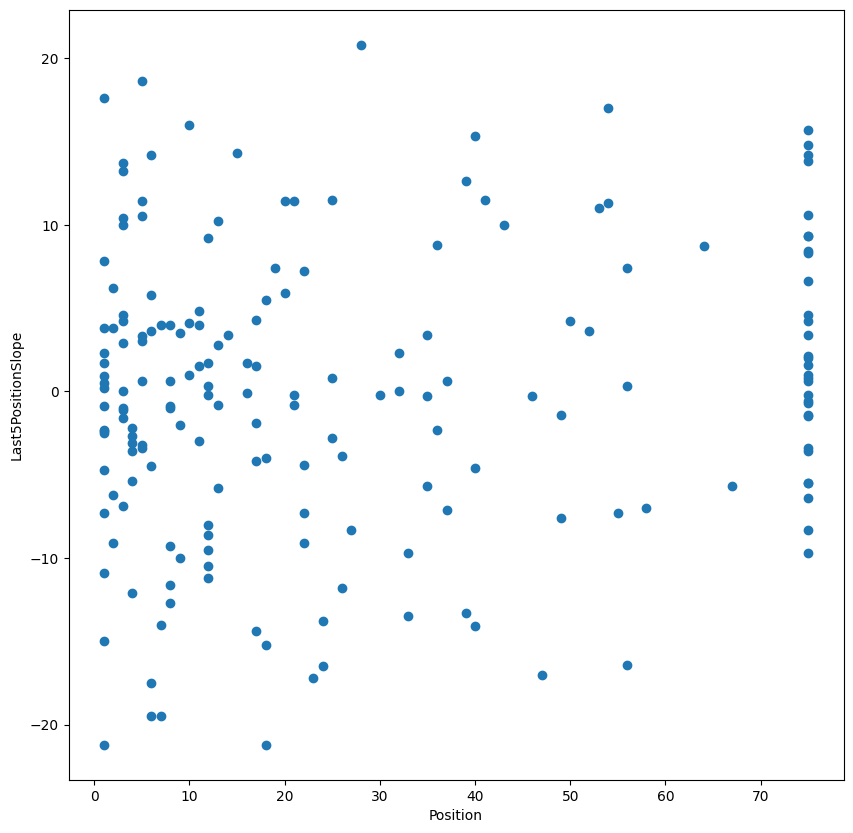

In [80]:
plot('Position','Last5PositionSlope',df)

In [171]:
df.corr()['Position'].sort_values(ascending=False)

Position               1.000000
Last3PositionAvg       0.154338
Last5PositionAvg       0.130043
Last10PositionAvg      0.129548
Last5PositionSlope     0.116812
Last10PositionSlope    0.096343
Last3PositionSlope     0.088877
Odds                  -0.047479
Name: Position, dtype: float64

In [172]:
df

,Position,Odds,Last10PositionAvg,Last5PositionAvg,Last3PositionAvg,Last10PositionSlope,Last5PositionSlope,Last3PositionSlope
TournamentID,,,,,,,,
526,25.0,10.5,35.8,23.0,16.666667,-3.88,-2.8,0.0
524,5.0,11.2,35.4,32.6,32.333333,0.07,-3.4,-6.0
520,40.0,15.5,31.9,39.6,23.333333,1.42,-14.1,-4.0
509,5.0,22.1,34.9,46.0,39.333333,3.05,-3.2,-0.5
508,52.0,22.9,30.5,36.2,47.000000,3.38,3.6,-31.0
...,...,...,...,...,...,...,...,...
21,50.0,NaN,37.8,50.0,44.666667,5.60,4.2,32.5
37,75.0,NaN,30.7,50.0,44.666667,4.96,-8.3,-13.0
15,49.0,NaN,33.8,43.6,42.000000,1.05,-1.4,-15.5


## Training:

In [136]:
features = ['Odds', 'Last10PositionAvg', 'Last5PositionAvg', 'Last3PositionAvg',
            'Last10PositionSlope', 'Last5PositionSlope', 'Last3PositionSlope']
labels = ['Position']

In [137]:
features_df = df[features]
labels_df = df[labels]

In [138]:
# split data into 90% training and 10% testing
x_train, x_test, y_train, y_test = train_test_split(features_df, labels_df, test_size=0.1)

In [139]:
model = XGBRegressor(random_state=SEED, objective='reg:squarederror')

model.fit(x_train,y_train)

get_score(model)

Cross-Validation Root Mean Squared Error: [26.23711776 25.87868248 23.83083726 26.9237183  41.12324894 31.83100366
 28.66332273 28.8386461 ]
Average Root Mean Squared Error: 29.16582
Standard deviation: 5.04126


In [162]:
preds = np.array(model.predict(x_test))

In [163]:
print(f'Model Predicted positions vs Actual Positions for {PLAYER} Previous Tournaments')
arr = []
for a,b in zip(preds, y_test.values):
    print(f'Predicted Position: {int(a)}, Actual Position: {int(*b,)}')
    arr.append(abs(int(a)-int(*b)))

Model Predicted positions vs Actual Positions for Justin Thomas Previous Tournaments
Predicted Position: 22, Actual Position: 13
Predicted Position: 26, Actual Position: 28
Predicted Position: 4, Actual Position: 12
Predicted Position: 17, Actual Position: 8
Predicted Position: 61, Actual Position: 22
Predicted Position: 12, Actual Position: 13
Predicted Position: 45, Actual Position: 1
Predicted Position: 42, Actual Position: 10
Predicted Position: 41, Actual Position: 1
Predicted Position: 11, Actual Position: 33
Predicted Position: 32, Actual Position: 1
Predicted Position: 15, Actual Position: 75
Predicted Position: 18, Actual Position: 1
Predicted Position: 21, Actual Position: 4
Predicted Position: 7, Actual Position: 75
Predicted Position: 18, Actual Position: 5
Predicted Position: 59, Actual Position: 56
Predicted Position: 29, Actual Position: 12
Predicted Position: 53, Actual Position: 3


In [109]:
get_results(preds)

Final RMSE: 31.72918


In [ ]:
final_pred = np.array(model.predict(df_next_tournament))[0]

In [ ]:
print(f'final prediction = {final_pred}')

In [164]:
x_test

,Odds,Last10PositionAvg,Last5PositionAvg,Last3PositionAvg,Last10PositionSlope,Last5PositionSlope,Last3PositionSlope
TournamentID,,,,,,,
435,14.0,15.8,25.0,12.333333,1.99,-5.8,3.0
142,NaN,54.9,47.6,75.000000,0.04,20.8,0.0
302,11.9,23.0,16.8,16.000000,-3.67,1.7,14.5
280,13.5,22.1,32.6,27.333333,2.15,-9.3,-34.5
124,NaN,37.0,53.8,51.666667,7.49,7.2,35.0
423,10.3,15.4,6.6,6.333333,-4.04,-0.8,-0.5
104,NaN,35.5,26.2,15.333333,-3.21,-7.3,-12.0
92,NaN,42.1,44.8,48.333333,0.14,4.1,4.0
255,10.5,14.1,12.6,9.000000,-1.91,-4.7,-8.0


In [165]:
y_test

,Position
TournamentID,
435,13.0
142,28.0
302,12.0
280,8.0
124,22.0
423,13.0
104,1.0
92,10.0
255,1.0
